In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install imbalanced-learn seaborn matplotlib scipy scikit-learn keras tensorflow numpy pandas

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler, RobustScaler
import scipy.io as sio
from os import listdir
from os.path import isfile, join
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras import regularizers
# Correction de l'import np_utils
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import zipfile
import tempfile
import os
import shutil
from sklearn.metrics import classification_report


In [ ]:
def to_one_hot(y):
    return to_categorical(y)  # Utilisation de to_categorical

def change(x):
    answer = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        max_value = max(x[i, :])
        max_index = list(x[i, :]).index(max_value)
        answer[i] = max_index
    return answer.astype(int)


def plot_class_distribution(y, title):
    plt.figure(figsize=(10, 6))
    counter = Counter(y.flatten())
    plt.bar(counter.keys(), counter.values())
    plt.title(title)
    plt.xlabel('Classes')
    plt.ylabel('Nombre d\'échantillons')
    class_names = ['Normal', 'AF', 'Other', 'Noise']
    plt.xticks(list(counter.keys()), class_names)
    for i, v in enumerate(counter.values()):
        plt.text(i, v, str(v), ha='center')
    plt.show()

def plot_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history['accuracy'], label='Train')
    ax1.set_title('Précision du modèle')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Précision de entrainement')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history.history['loss'], label='Train')
    ax2.set_title('Perte de entrainement')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Perte')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


# The plot_learning_curves_Val function was incorrectly nested inside plot_learning_curves
# It has been moved to the outer scope and properly indented.
def plot_learning_curves_Val(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title('Précision du modèle')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Précision de la validation')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title('Perte de la validation')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Perte')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    class_names = ['Normal', 'AF', 'Other', 'Noise']
    cm = confusion_matrix(y_true, y_pred)

    # Matrice de confusion en valeurs absolues
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Matrice de confusion')
    plt.ylabel('Vraie classe')
    plt.xlabel('Classe prédite')
    plt.show()

    # Matrice de confusion en pourcentages
    cm_percent = cm.astype('float') / cm.sum()

In [ ]:
# Variables principales
number_of_classes = 4
check = 100
big = 10100

# Création d'un dossier temporaire pour extraire les fichiers
temp_dir = tempfile.mkdtemp()

try:
    # Extraction du zip
    with zipfile.ZipFile('/content/drive/MyDrive/training2017.zip', 'r') as zip_ref:
        zip_ref.extractall(temp_dir)

    # Mise à jour du chemin vers les données
    mypath = join(temp_dir, 'training2017')

    # Chargement des données
    onlyfiles = [f for f in listdir(mypath) if (isfile(join(mypath, f)) and f[0] == 'A')]
    bats = [f for f in onlyfiles if f[7] == 'm']
    mats = [f for f in bats if (np.shape(sio.loadmat(join(mypath, f))['val'])[1] >= check)]

    size = len(mats)
    print('Total training size is ', size)

    X = np.zeros((size, big))
    for i in range(size):
        dummy = sio.loadmat(join(mypath, mats[i]))['val'][0, :]
        if (big - len(dummy)) <= 0:
            X[i, :] = dummy[0:big]
        else:
            b = dummy[0:(big - len(dummy))]
            goal = np.hstack((dummy, b))
            while len(goal) != big:
                b = dummy[0:(big - len(goal))]
                goal = np.hstack((goal, b))
            X[i, :] = goal

    # Vérification et nettoyage des données
    print("\nVérification des données:")
    print(f"Valeurs manquantes dans X: {np.isnan(X).sum()}")
    X = np.nan_to_num(X, nan=0.0)

    target_train = np.zeros((size, 1))
    Train_data = pd.read_csv(join(mypath, 'REFERENCE.csv'), header=None)

    for i in range(size):
        if Train_data.loc[Train_data[0] == mats[i][:6], 1].values == 'N':
            target_train[i] = 0
        elif Train_data.loc[Train_data[0] == mats[i][:6], 1].values == 'A':
            target_train[i] = 1
        elif Train_data.loc[Train_data[0] == mats[i][:6], 1].values == 'O':
            target_train[i] = 2
        else:
            target_train[i] = 3

finally:
    # Nettoyage du dossier temporaire
    shutil.rmtree(temp_dir)

Total training size is  8528

Vérification des données:
Valeurs manquantes dans X: 0


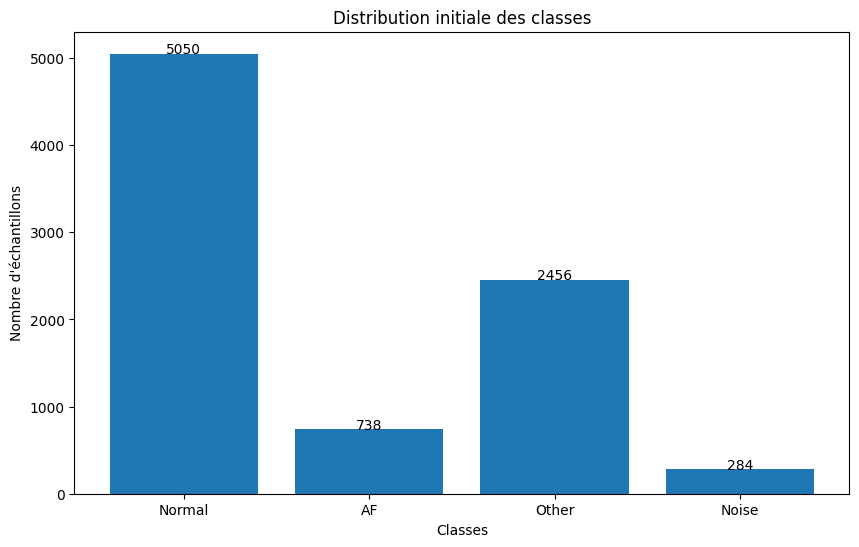

Train size: (7675, 10100, 1) (7675, 4)
Validation size: (853, 10100, 1) (853, 4)


In [ ]:
# Visualisation de la distribution initiale
plot_class_distribution(target_train, "Distribution initiale des classes")

# Normalisation des données
X = (X - X.mean()) / (X.std())
X = np.expand_dims(X, axis=2)
Label_set = to_one_hot(target_train)

# Mélange des données
permutations = np.random.permutation(len(X))
X = X[permutations]
Label_set = Label_set[permutations]

train = 0.9  # Size of training set in percentage
X_train = X[:int(train * size), :]
Y_train = Label_set[:int(train * size), :]
X_val = X[int(train * size):, :]
Y_val = Label_set[int(train * size):, :]
'''
# Appliquer SMOTE sur l'ensemble d'entraînement
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
smote = SMOTE(random_state=42)
X_train_balanced, Y_train_balanced = smote.fit_resample(X_train_reshaped, Y_train.argmax(axis=1))
X_train = X_train_balanced.reshape(-1, big, 1)
Y_train = to_one_hot(Y_train_balanced)
'''

# Vérification des tailles des ensembles
print("Train size:", X_train.shape, Y_train.shape)
print("Validation size:", X_val.shape, Y_val.shape)
#print("Test size:", X_test.shape, Y_test.shape)

# Visualisation après équilibrage
#plot_class_distribution(Y_train_balanced, "Distribution des classes après équilibrage - Train")


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.metrics import Precision, Recall, F1Score


# Définition du modèle CNN
model = Sequential()

# Première couche convolutionnelle avec BatchNormalization
model.add(Conv1D(128, 55, activation='relu', input_shape=(big, 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(10))
model.add(Dropout(0.5))

# Deuxième couche convolutionnelle avec BatchNormalization
model.add(Conv1D(128, 25, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(5))
model.add(Dropout(0.5))

# Troisième couche convolutionnelle avec BatchNormalization
model.add(Conv1D(128, 10, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(5))
model.add(Dropout(0.5))

# Quatrième couche convolutionnelle avec BatchNormalization
model.add(Conv1D(128, 5, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling1D())

# Couches denses avec BatchNormalization et Dropout
model.add(Dense(256, kernel_initializer='normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, kernel_initializer='normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, kernel_initializer='normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Couche de sortie
model.add(Dense(number_of_classes, kernel_initializer='normal', activation='softmax'))

# Résumé du modèle
model.summary()


#class_weights = {0: 7.0, 1: 2.0, 2: 1.0, 3: 18.0}  # Ajustez en fonction de votre déséquilibre

# Compilation du modèle
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy', Recall(), Precision(), F1Score()] )

# Callbacks
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    factor=0.5,
    min_lr=1e-6,
    patience=2,
    verbose=1,
    monitor='val_loss'
)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 10046, 128)          │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 10046, 128)          │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 1004, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1004, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 980, 128)            │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 980, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 196, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 196, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 187, 128)            │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 187, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 37, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 37, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 33, 128)             │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 33, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 741,188 (2.83 MB)

 Trainable params: 739,268 (2.82 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y_train.argmax(axis=1)),
    y=Y_train.argmax(axis=1)
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: 0.42031763417305584, 1: 2.9293893129770994, 2: 0.8701814058956916, 3: 7.675}


Epoch 1/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 48s 131ms/step - accuracy: 0.2601 - f1_score: 0.2252 - loss: 1.3444 - precision: 0.2628 - recall: 0.0422 - val_accuracy: 0.1008 - val_f1_score: 0.0758 - val_loss: 1.7691 - val_precision: 0.0420 - val_recall: 0.0270 - learning_rate: 0.0010
Epoch 2/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.3692 - f1_score: 0.3159 - loss: 1.1202 - precision: 0.3086 - recall: 0.0820 - val_accuracy: 0.4947 - val_f1_score: 0.3581 - val_loss: 1.1884 - val_precision: 0.5405 - val_recall: 0.3834 - learning_rate: 0.0010
Epoch 3/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - accuracy: 0.5397 - f1_score: 0.4188 - loss: 0.9341 - precision: 0.6087 - recall: 0.3233 - val_accuracy: 0.6213 - val_f1_score: 0.4813 - val_loss: 0.9115 - val_precision: 0.6609 - val_recall: 0.5780 - learning_rate: 0.0010
Epoch 4/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.5939 - f1_score: 0.4781 - loss: 0.8651 - precision: 0.6559 - recall: 0.4612 - val_accuracy: 0.691

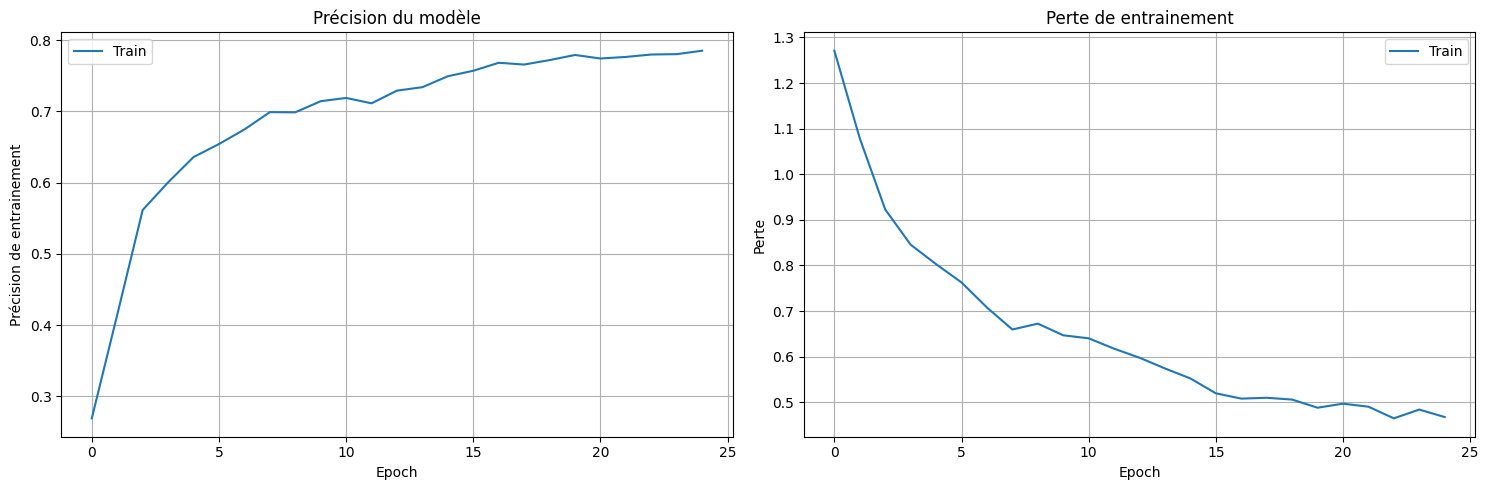

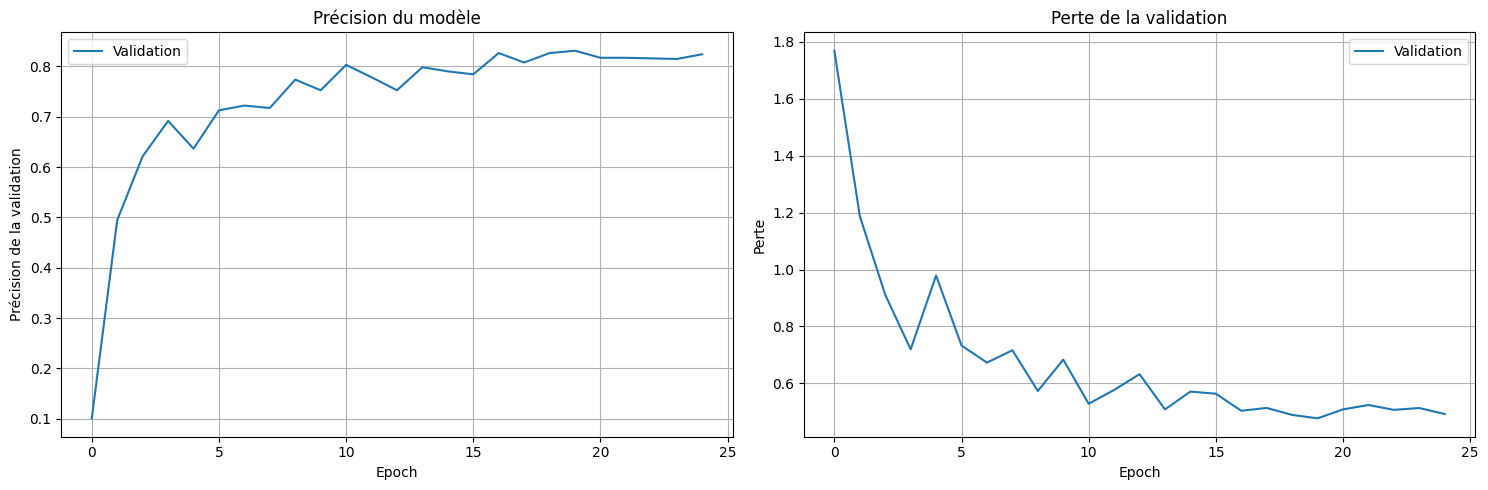

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


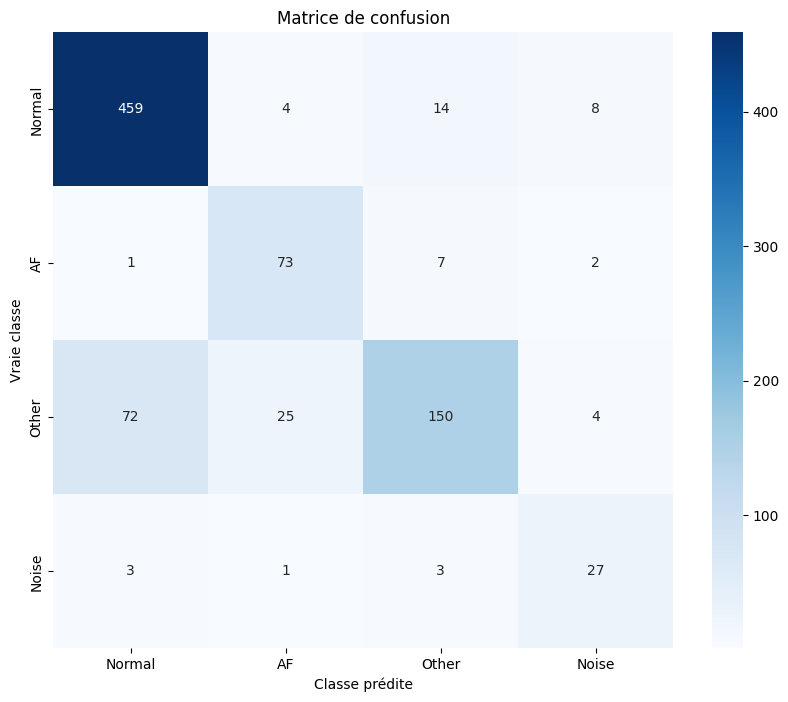

              precision    recall  f1-score   support

           0       0.86      0.95      0.90       485
           1       0.71      0.88      0.78        83
           2       0.86      0.60      0.71       251
           3       0.66      0.79      0.72        34

    accuracy                           0.83       853
   macro avg       0.77      0.80      0.78       853
weighted avg       0.84      0.83      0.82       853

Score de test final: 0.8311840562719812


In [ ]:
# Entraînement
hist = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

# Visualisation des courbes d'apprentissage
plot_learning_curves(hist)
plot_learning_curves_Val(hist)

# Prédictions et évaluation sur l'ensemble de test
predictions = model.predict(X_val)
y_true = change(Y_val)
y_pred = change(predictions)

# Matrice de confusion et rapport de classification
plot_confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred))

# Score de précision
score = accuracy_score(y_true, y_pred)
print('Score de test final:', score)
